# Tiny ImageNet Classification with PyTorch

### Classification with ResNet-18

By: Kenneth Leung
___

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/{user_name}/{repo_name}/blob/{branch_name}/path/to/notebook.ipynb)

___
### 1. Initial setup

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import models, datasets
from torchvision import transforms as T
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

import opendatasets as od
from random import randint
import urllib
import zipfile
from aim import Session

# Define device to use (CPU or GPU). CUDA = GPU support for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

### Import Datasets

#### Method 1 - Kaggle (Local download)

In [ ]:
# od.download("https://www.kaggle.com/akash2sharma/tiny-imagenet")

#### Method 2 - Direct download (Google Colab)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
# Retrieve data directly
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
# !unzip -qq 'tiny-imagenet-200.zip'

___

In [2]:
# Define directory paths
setup = 'Local' # Local or Colab

if setup == 'Local':
    DATA_DIR = 'tiny-imagenet/tiny-imagenet-200'
else:
    DATA_DIR = 'tiny-imagenet-200'

TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'val')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Original images come in shape of [3,64,64]

___
### 2. Setup helper functions

In [3]:
# Functions to display single or a batch of sample images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
def show_batch(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()    
    imshow(make_grid(images)) # Using Torchvision.utils make_grid function
    
    
def show_image(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    random_num = randint(0, len(images)-1)
    imshow(images[random_num])
    label = labels[random_num]
    print(f'Label: {label}, Shape: {images[random_num].shape}')

In [4]:
def generate_dataloader(data, name, transform):
    if data is None: 
        return None
    
    # Read image files to pytorch dataset with ImageFolder, a generic data 
    # loader where images are in format root/label/filename
    # See https://pytorch.org/vision/stable/datasets.html
    if transform is None:
        dataset = datasets.ImageFolder(data, transform=T.ToTensor())
    else:
        dataset = datasets.ImageFolder(data, transform=transform)

    # Set options for device
    if use_cuda:
        kwargs = {"pin_memory": True, "num_workers": 1}
    else:
        kwargs = {}
    
    # Wrap image dataset (defined above) in dataloader 
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                        shuffle=(name=="train"), 
                        **kwargs)
    
    return dataloader

___
### Define Image Pre-processing Transformations
PyTorch transforms define image transformations that convert all images in dataset into a standardized format.

In [5]:
# Define transformation sequence for image pre-processing
# If not using pre-trained model, normalize with 0.5, 0.5, 0.5 (mean and SD)
# If using pre-trained Imagenet, normalize with mean=[0.485, 0.456, 0.406], 
# std=[0.229, 0.224, 0.225])

preprocess_transform = T.Compose([
#                 T.Resize(256), # Resize images to 256 x 256
#                 T.CenterCrop(224), # Center crop image
                T.RandomResizedCrop(58),
                T.RandomHorizontalFlip(),
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # 
])

___
### Define hyperparameters

Reference: https://blog.paperspace.com/dataloaders-abstractions-pytorch/

In [6]:
lr = 0.001  # Learning rate
batch_size = 64  # Images per batch
num_epochs = 3  # Number of epochs

# Set up logging
print_every = 1  # Number of batches

___
### Create dataloaders

#### Training set dataloader

In [ ]:
# train_loader = generate_dataloader(TRAIN_DIR, "train",
#                                   transform=None) # No transformations

# # Display batch of UNprocessed images from train set
# show_batch(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


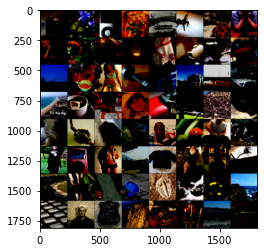

In [7]:
train_loader = generate_dataloader(TRAIN_DIR, "train",
                                  transform=preprocess_transform)

# Display batch of processed images
show_batch(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


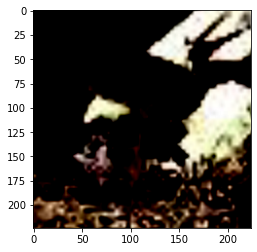

Label: 20, Shape: torch.Size([3, 224, 224])


In [8]:
# Display single random image from train dataset
show_image(train_loader)

#### Validation set dataloader

In [9]:
# Unlike the training folder where the images are already arranged in 
# sub folders based on their labels, the images in the validation folder 
# are all collated in a single folder. The validation folder comes with 
# images folder and val_annotations txt file. The val_annotation txt file 
# comprises 6 tab separated columns of filename, class label, x and y 
# coordinates and height, width of bounding box
val_data = pd.read_csv(f'{VALID_DIR}/val_annotations.txt', 
                       sep='\t', 
                       header=None, 
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])

val_data.head()

,File,Class,X,Y,H,W
0,val_0.JPEG,n03444034,0,32,44,62
1,val_1.JPEG,n04067472,52,55,57,59
2,val_2.JPEG,n04070727,4,0,60,55
3,val_3.JPEG,n02808440,3,3,63,63
4,val_4.JPEG,n02808440,9,27,63,48


In [10]:
# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(VALID_DIR, 'images')

# Open and read val annotations text file
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Display first 10 entries of resulting val_img_dict dictionary
{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'val_0.JPEG': 'n03444034',
 'val_1.JPEG': 'n04067472',
 'val_2.JPEG': 'n04070727',
 'val_3.JPEG': 'n02808440',
 'val_4.JPEG': 'n02808440',
 'val_5.JPEG': 'n04399382',
 'val_6.JPEG': 'n04179913',
 'val_7.JPEG': 'n02823428',
 'val_8.JPEG': 'n04146614',
 'val_9.JPEG': 'n02226429'}

In [ ]:
# Create subfolders (if not present) for validation images based on label ,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

In [11]:
# Save class names (for corresponding labels) as dict from words.txt file
class_to_name_dict = dict()
fp = open(os.path.join(DATA_DIR, 'words.txt'), 'r')
data = fp.readlines()
for line in data:
    words = line.strip('\n').split('\t')
    class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

# Display first 20 entries of resulting dictionary
{k: class_to_name_dict[k] for k in list(class_to_name_dict)[:20]}

<IPython.core.display.Javascript object>

{'n00001740': 'entity',
 'n00001930': 'physical entity',
 'n00002137': 'abstraction',
 'n00002452': 'thing',
 'n00002684': 'object',
 'n00003553': 'whole',
 'n00003993': 'congener',
 'n00004258': 'living thing',
 'n00004475': 'organism',
 'n00005787': 'benthos',
 'n00005930': 'dwarf',
 'n00006024': 'heterotroph',
 'n00006150': 'parent',
 'n00006269': 'life',
 'n00006400': 'biont',
 'n00006484': 'cell',
 'n00007347': 'causal agent',
 'n00007846': 'person',
 'n00015388': 'animal',
 'n00017222': 'plant'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


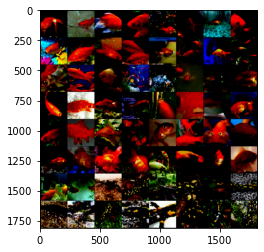

In [12]:
val_loader = generate_dataloader(val_img_dir, "val",
                                 transform=preprocess_transform)

# Display batch of processed images
show_batch(val_loader)

___
### Setup model

In [ ]:
model = models.resnet18(pretrained=False)
num_classes = 200
model.fc = torch.nn.Linear(in_features=model.fc.in_features, 
                           out_features=num_classes, 
                           bias=True)
model = model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

___
### Begin model training

In [ ]:
# Set up pytorch-ignite trainer and evaluator.
trainer = create_supervised_trainer(
    model,
    optimizer,
    loss_func,
    device=device,
)
metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(loss_func),
}
evaluator = create_supervised_evaluator(
    model, metrics=metrics, device=device
)

@trainer.on(Events.ITERATION_COMPLETED(every=print_every))
def log_batch(trainer):
    batch = (trainer.state.iteration - 1) % trainer.state.epoch_length + 1
    print(
        f"Epoch {trainer.state.epoch} / {num_epochs}, "
        f"batch {batch} / {trainer.state.epoch_length}: "
        f"loss: {trainer.state.output:.3f}"
    )

@trainer.on(Events.EPOCH_COMPLETED)
def log_epoch(trainer):
    print(f"Epoch {trainer.state.epoch} / {num_epochs} average results: ")

    def log_results(name, metrics, epoch):
        print(
            f"{name + ':':6} loss: {metrics['loss']:.3f}, "
            f"accuracy: {metrics['accuracy']:.3f}"
        )

    # Train data.
    evaluator.run(train_loader)
    log_results("train", evaluator.state.metrics, trainer.state.epoch)

    # Val data.
    if val_loader:
        evaluator.run(val_loader)
        log_results("val", evaluator.state.metrics, trainer.state.epoch)

    # Test data.
    if test_loader:
        evaluator.run(test_loader)
        log_results("test", evaluator.state.metrics, trainer.state.epoch)

    print()
    print("-" * 80)
    print()

# Start training.
trainer.run(train_loader, max_epochs=num_epochs)

___
### References
- https://github.com/ZohebAbai/Tiny-ImageNet-Challenge/blob/master/TinyImageNet_Network_1.ipynb
- https://blog.paperspace.com/dataloaders-abstractions-pytorch/
- https://github.com/DennisHanyuanXu/Tiny-ImageNet/blob/master/src/data_prep.py)
- https://www.kaggle.com/ivankunyankin/resnet18-from-scratch-using-pytorch
- http://cs231n.stanford.edu/reports/2015/pdfs/banerjee_iyer.pdf